#Birds Speciees Rocognition:
"A diverse collection of six unique bird species for image classification"


---


Problem selection:

*   Imagine a blind person that want to go to a ornithological parc, to listen to the birds, yes he can listen but does not know which species are there. The point of this "project" is to implement a CNN model and to finetunning it. The model will be able to recognize bird's species taking pictures as input.



In [42]:
# Monter Google Drive
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Here we orgenize the dataset, for being processed later. As the dataset is pretty small, we will do 70% for training, and 15% for validation and test.

In [32]:
import os
import shutil
import random
from pathlib import Path

# Chemin d'accès à votre dossier d'images d'oiseaux dans Google Drive
dataset_dir = Path('/content/gdrive/MyDrive/birds/Bird Speciees Dataset')  # Remplacez par le chemin correct

# Créer les dossiers pour train, validation et test
train_dir = dataset_dir / 'train'
val_dir = dataset_dir / 'validation'
test_dir = dataset_dir / 'test'

# Supprimer les dossiers de destination s'ils existent déjà pour éviter le doublement de la séparation
for subset_dir in [train_dir, val_dir, test_dir]:
    if subset_dir.exists():
        shutil.rmtree(subset_dir)
    subset_dir.mkdir(parents=True, exist_ok=True)

# Paramètres de répartition
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Parcourir chaque classe (espèce d'oiseau) dans le dossier principal (exclut train, validation, test)
for bird_class in os.listdir(dataset_dir):
    class_dir = dataset_dir / bird_class
    if class_dir.is_dir() and bird_class not in ['train', 'validation', 'test']:
        # Obtenir toutes les images de cette classe
        images = list(class_dir.glob('*.jpg')) + list(class_dir.glob('*.png'))
        random.shuffle(images)

        # Calculer les indices pour division
        train_end = int(train_ratio * len(images))
        val_end = train_end + int(val_ratio * len(images))

        # Diviser les images entre train, validation, et test
        for i, img_path in enumerate(images):
            if i < train_end:
                subset_dir = train_dir / bird_class
            elif i < val_end:
                subset_dir = val_dir / bird_class
            else:
                subset_dir = test_dir / bird_class

            # Créer le sous-dossier pour la classe s'il n'existe pas
            subset_dir.mkdir(parents=True, exist_ok=True)

            # Copier l'image dans le sous-dossier approprié
            shutil.copy(img_path, subset_dir / img_path.name)

print("Séparation terminée !")


Séparation terminée !


Now our data is ready, we will try three different models, and then decide which one to use for the improvment.

#EfficientNetB0

In [10]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Chemins des dossiers de données
train_dir = '/content/gdrive/MyDrive/birds/Bird Speciees Dataset/train'
val_dir = '/content/gdrive/MyDrive/birds/Bird Speciees Dataset/validation'
test_dir = '/content/gdrive/MyDrive/birds/Bird Speciees Dataset/test'

# Paramètres du modèle
batch_size = 32
img_height, img_width = 224, 224  # Taille d'entrée pour EfficientNetB0
num_classes = 6  # Nombre de classes d'oiseaux

# Préparation des générateurs de données avec augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1.0/255)

# Générateurs d'images
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 565 images belonging to 6 classes.
Found 118 images belonging to 6 classes.
Found 128 images belonging to 6 classes.


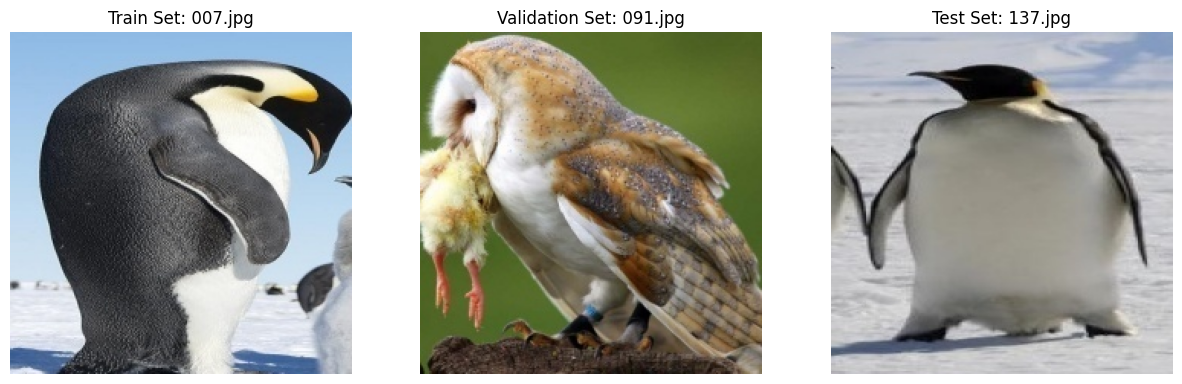

In [11]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt

# Fonction pour afficher une image aléatoire d'un ensemble donné
def display_random_image_from_directory(directory, title):
    # Sélectionner un sous-dossier aléatoire (classe)
    class_dir = random.choice([os.path.join(directory, d) for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))])
    # Sélectionner une image aléatoire dans ce dossier
    image_path = random.choice([os.path.join(class_dir, f) for f in os.listdir(class_dir) if f.endswith(('jpg', 'jpeg', 'png'))])
    # Charger et afficher l'image
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(f"{title}: {os.path.basename(image_path)}")
    plt.axis('off')

# Afficher une image de chaque ensemble
plt.figure(figsize=(15, 5))

# Image du set d'entraînement
plt.subplot(1, 3, 1)
display_random_image_from_directory(train_dir, "Train Set")

# Image du set de validation
plt.subplot(1, 3, 2)
display_random_image_from_directory(val_dir, "Validation Set")

# Image du set de test
plt.subplot(1, 3, 3)
display_random_image_from_directory(test_dir, "Test Set")

plt.show()


Epoch 1/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.1600 - loss: 1.8147 - val_accuracy: 0.1695 - val_loss: 1.7977
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 49s 350ms/step - accuracy: 0.1840 - loss: 1.7985 - val_accuracy: 0.1695 - val_loss: 1.7918
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 306ms/step - accuracy: 0.1410 - loss: 1.8002 - val_accuracy: 0.1610 - val_loss: 1.7920
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 290ms/step - accuracy: 0.1569 - loss: 1.7910 - val_accuracy: 0.1780 - val_loss: 1.7917
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 380ms/step - accuracy: 0.1444 - loss: 1.7968 - val_accuracy: 0.1780 - val_loss: 1.7926
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 314ms/step - accuracy: 0.1742 - loss: 1.7897 - val_accuracy: 0.1610 - val_loss: 1.7922
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 303ms/step - accuracy: 0.1574 - loss: 1.7937 - val_accuracy: 0.1780 - val_loss: 1.7915
Epoch 8/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 354ms/step - accuracy: 0.1794 - loss: 1.7916 - val_accuracy: 

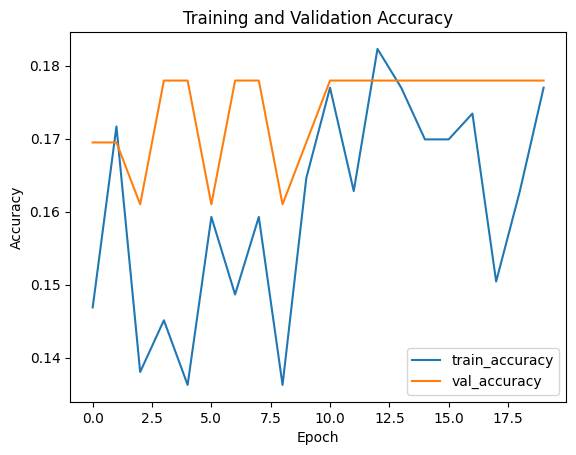

In [12]:

# Charger le modèle EfficientNetB0 avec des poids pré-entraînés
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Ajouter des couches de classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dense(num_classes, activation='softmax')(x)  # Couche de sortie

# Construire le modèle final
model = Model(inputs=base_model.input, outputs=x)

# Geler les couches du modèle de base pour un fine-tuning
for layer in base_model.layers:
    layer.trainable = False

# Compiler le modèle
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Entraîner le modèle
epochs = 20  # Peut être ajusté pour améliorer la performance
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator
)

# Évaluer sur le set de test
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc:.2f}")

# Optionnel : Afficher les courbes d'entraînement
import matplotlib.pyplot as plt

# Afficher l'évolution de la précision
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()


#ResNet50

Found 565 images belonging to 6 classes.
Found 118 images belonging to 6 classes.
Found 128 images belonging to 6 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


18/18 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.1711 - loss: 2.0266 - val_accuracy: 0.2542 - val_loss: 1.7816
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 277ms/step - accuracy: 0.2519 - loss: 1.7427 - val_accuracy: 0.3475 - val_loss: 1.5937
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 261ms/step - accuracy: 0.3281 - loss: 1.5797 - val_accuracy: 0.4407 - val_loss: 1.4252
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 260ms/step - accuracy: 0.3182 - loss: 1.5501 - val_accuracy: 0.3898 - val_loss: 1.4395
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 261ms/step - accuracy: 0.4162 - loss: 1.4391 - val_accuracy: 0.4576 - val_loss: 1.3912
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 264ms/step - accuracy: 0.3863 - loss: 1.5198 - val_accuracy: 0.5593 - val_loss: 1.2772
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 265ms/step - accuracy: 0.4682 - loss: 1.4522 - val_accuracy: 0.6102 - val_loss: 1.2335
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 256ms/step - accuracy: 0.4358 - loss: 1.3332 - val_accuracy: 0.5508 -

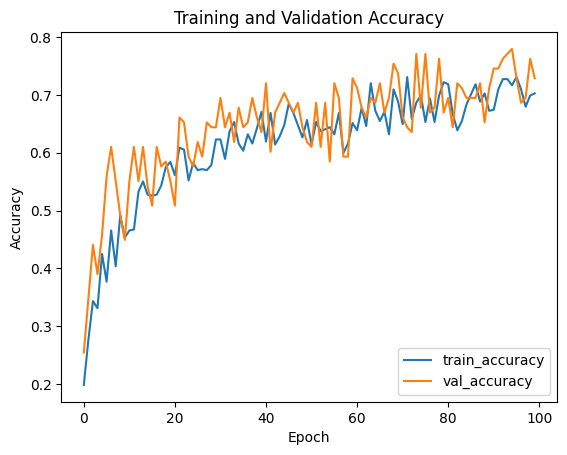

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50  # Utiliser ResNet50, car ResNet18 n'est pas directement disponible dans Keras
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Chemins des dossiers de données
train_dir = '/content/gdrive/MyDrive/birds/Bird Speciees Dataset/train'
val_dir = '/content/gdrive/MyDrive/birds/Bird Speciees Dataset/validation'
test_dir = '/content/gdrive/MyDrive/birds/Bird Speciees Dataset/test'

# Paramètres du modèle
batch_size = 32
img_height, img_width = 224, 224  # Taille d'entrée pour ResNet50
num_classes = len(os.listdir(train_dir))  # Nombre de classes d'oiseaux

# Préparation des générateurs de données avec augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1.0/255)

# Générateurs d'images
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Charger le modèle ResNet50 pré-entraîné (utilisé en remplacement de ResNet18)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Ajouter des couches de classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
output_layer = Dense(num_classes, activation='softmax')(x)  # Couche de sortie

# Construire le modèle final
model = Model(inputs=base_model.input, outputs=output_layer)

# Geler les couches du modèle de base pour un fine-tuning initial
for layer in base_model.layers:
    layer.trainable = False

# Compiler le modèle
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Entraîner le modèle
epochs = 100  # Peut être ajusté selon les besoins
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator
)

# Évaluer sur le set de test
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc * 100:.2f}%")

# Optionnel : Afficher les courbes d'entraînement
import matplotlib.pyplot as plt

# Afficher l'évolution de la précision
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()


#InceptionV3

In [44]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Chemins des dossiers de données
train_dir = '/content/gdrive/MyDrive/birds/Bird Speciees Dataset/train'
val_dir = '/content/gdrive/MyDrive/birds/Bird Speciees Dataset/validation'
test_dir = '/content/gdrive/MyDrive/birds/Bird Speciees Dataset/test'

# Paramètres du modèle
batch_size = 32
img_height, img_width = 299, 299  # Taille d'entrée pour InceptionV3

# Préparation des générateurs de données avec augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1.0/255)

# Générateurs d'images
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 565 images belonging to 6 classes.
Found 118 images belonging to 6 classes.
Found 128 images belonging to 6 classes.


Classes détectées :  {'AMERICAN GOLDFINCH': 0, 'BARN OWL': 1, 'CARMINE BEE-EATER': 2, 'DOWNY WOODPECKER': 3, 'EMPEROR PENGUIN': 4, 'FLAMINGO': 5}
Nombre de classes :  6
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 167s 4s/step - accuracy: 0.6560 - loss: 1.0447 - val_accuracy: 0.9492 - val_loss: 0.1468
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 13s 458ms/step - accuracy: 1.0000 - loss: 0.0310 - val_accuracy: 1.0000 - val_loss: 0.0131
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 13s 454ms/step - accuracy: 1.0000 - loss: 0.0076 - val_accuracy: 1.0000 - val_loss: 0.0023
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 13s 450ms/step - accuracy: 0.9958 - loss: 0.0080 - val_accuracy: 1.0000 - val_loss: 0.0021
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 13s 454ms/step - accuracy: 1.0000 - loss: 0.0021 - val_accuracy: 1.0000 - val_loss: 0.0014
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 13s 466ms/step - accuracy: 1.0000 - loss: 0.0025 - val_accuracy: 1.0000 - val_loss: 7.4668e-04
Epoc

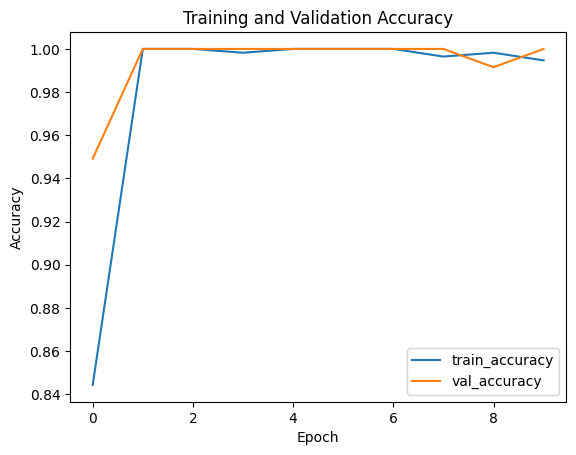

In [45]:

# Vérification du nombre de classes détectées
print("Classes détectées : ", train_generator.class_indices)
num_classes = len(train_generator.class_indices)
print("Nombre de classes : ", num_classes)

# Charger le modèle InceptionV3 pré-entraîné
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Ajouter des couches de classification avec Dropout
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)  # Dropout pour éviter le surapprentissage
output_layer = Dense(num_classes, activation='softmax')(x)  # Couche de sortie

# Construire le modèle final
model = Model(inputs=base_model.input, outputs=output_layer)

# Dégeler certaines couches pour un fine-tuning plus profond
for layer in base_model.layers[-20:]:  # Dégeler les 20 dernières couches
    layer.trainable = True

# Compiler le modèle
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Entraîner le modèle
epochs = 10  # Ajustez si besoin
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator
)

# Évaluer sur le set de test
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc * 100:.2f}%")

# Optionnel : Afficher les courbes d'entraînement
import matplotlib.pyplot as plt

# Afficher l'évolution de la précision
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()




---
We could use the InceptionV3 achitecture but it is already perfect, so we will use the ResNet50n. For the moment we have this results at the 100th epcoh_:


---



*   Epoch 100/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 415ms/step - accuracy: 0.7213 - loss: 0.7908 - val_accuracy: 0.6780 - val_loss: 0.9760
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.6667 - loss: 0.8266
Test accuracy: 65.62%


---




We clearly see a difference betweeen accuracy on training results of ~72% and accuracy on test: ~65.6%. This cis a sign of Overfitting, due to our hyperparamter first selection and the small size of the dataset, our model is momorizing too much and not getting the birds patterns.

For that reason we will use a regularization method, considering also than our dataset is small, we will begin with data augmentation. For the previous model we was already doing it with this setup:

---

    train_datagen = ImageDataGenerator(
        rescale=1.0/255, :Normalizes pixel values ​​to bring them into a range of 0 to 1
        rotation_range=15, :Rotates images randomly within a range of -15 to +15 degrees.
        width_shift_range=0.1, :Randomly shift images horizontally
        height_shift_range=0.1, :Randomly shift images vertically
        shear_range=0.1, :Applies shear distortion to images, distorts the image by skewing its contents horizontally or vertically up to 10%.
        zoom_range=0.1, :Randomly zooms in or out (+/- 10%)
        horizontal_flip=True :Randomly flip images horizontally
    )

This are the new transformation that we will apply, bit more strong and often than the previous one:
---
    train_datagen = ImageDataGenerator(
        rescale=1.0/255,
        rotation_range=45,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=[0.8, 1.2],
        horizontal_flip=True,
        brightness_range=[0.7, 1.3]
    )


In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50  # Utiliser ResNet50, car ResNet18 n'est pas directement disponible dans Keras
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
# Chemins des dossiers de données
train_dir = '/content/gdrive/MyDrive/birds/Bird Speciees Dataset/train'
val_dir = '/content/gdrive/MyDrive/birds/Bird Speciees Dataset/validation'
test_dir = '/content/gdrive/MyDrive/birds/Bird Speciees Dataset/test'

# Paramètres du modèle
batch_size = 32
img_height, img_width = 224, 224  # Taille d'entrée pour ResNet50
num_classes = len(os.listdir(train_dir))  # Nombre de classes d'oiseaux


def add_noise(image):
    img_array = img_to_array(image)
    noise = np.random.normal(loc=0, scale=25, size=img_array.shape)
    img_array = img_array + noise
    img_array = np.clip(img_array, 0, 255)
    return array_to_img(img_array)

train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=[0.8, 1.2],
    horizontal_flip=True,
    brightness_range=[0.7, 1.3],
    preprocessing_function=add_noise  # Ajoute du bruit aléatoire
)

val_test_datagen = ImageDataGenerator(rescale=1.0/255)

# Générateurs d'images
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 565 images belonging to 6 classes.
Found 118 images belonging to 6 classes.
Found 128 images belonging to 6 classes.


Found 565 images belonging to 6 classes.


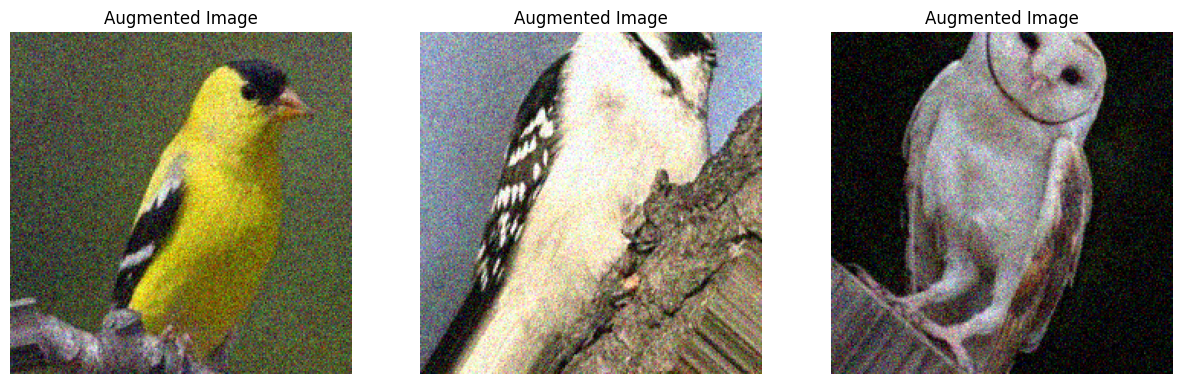

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img

# Fonction de bruit corrigée pour retourner un tableau NumPy
def add_noise(image):
    img_array = img_to_array(image)
    noise = np.random.normal(loc=0, scale=25, size=img_array.shape)
    img_array = img_array + noise
    img_array = np.clip(img_array, 0, 255)
    return img_array  # Retourner le tableau NumPy sans le convertir en image

# Redéfinir l'ImageDataGenerator avec la fonction corrigée
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=[0.8, 1.2],
    horizontal_flip=True,
    brightness_range=[0.7, 1.3],
    preprocessing_function=add_noise
)

# Générer un batch d'images avec data augmentation
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

# Afficher 3 images transformées
images, labels = next(train_generator)
plt.figure(figsize=(15, 5))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(images[i])
    plt.axis('off')
    plt.title("Augmented Image")
plt.show()


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


18/18 ━━━━━━━━━━━━━━━━━━━━ 27s 776ms/step - accuracy: 0.1756 - loss: 2.0884 - val_accuracy: 0.2966 - val_loss: 1.6898
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 392ms/step - accuracy: 0.2437 - loss: 1.7483 - val_accuracy: 0.2712 - val_loss: 1.6495
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 12s 411ms/step - accuracy: 0.2910 - loss: 1.6891 - val_accuracy: 0.3136 - val_loss: 1.6005
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 380ms/step - accuracy: 0.3385 - loss: 1.6095 - val_accuracy: 0.4068 - val_loss: 1.5888
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 377ms/step - accuracy: 0.3099 - loss: 1.6051 - val_accuracy: 0.3729 - val_loss: 1.5216
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 378ms/step - accuracy: 0.3311 - loss: 1.6054 - val_accuracy: 0.3983 - val_loss: 1.4778
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 378ms/step - accuracy: 0.3363 - loss: 1.6336 - val_accuracy: 0.3559 - val_loss: 1.6317
Epoch 8/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 383ms/step - accuracy: 0.2962 - loss: 1.6503 - val_accuracy: 0.457

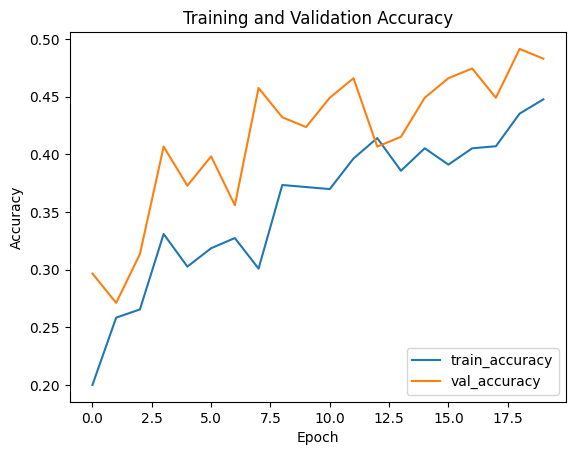

In [12]:

# Charger le modèle ResNet50 pré-entraîné (utilisé en remplacement de ResNet18)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Ajouter des couches de classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
output_layer = Dense(num_classes, activation='softmax')(x)  # Couche de sortie

# Construire le modèle final
model = Model(inputs=base_model.input, outputs=output_layer)

# Geler les couches du modèle de base pour un fine-tuning initial
for layer in base_model.layers:
    layer.trainable = False

# Compiler le modèle
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Entraîner le modèle
epochs = 20  # Peut être ajusté selon les besoins
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator
)

# Évaluer sur le set de test
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc * 100:.2f}%")

# Optionnel : Afficher les courbes d'entraînement
import matplotlib.pyplot as plt

# Afficher l'évolution de la précision
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()


Still signs of overfitt, we will add the dropout technique.

Found 565 images belonging to 6 classes.
Found 118 images belonging to 6 classes.
Found 128 images belonging to 6 classes.
Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 24s 659ms/step - accuracy: 0.1931 - loss: 1.9527 - val_accuracy: 0.3051 - val_loss: 1.7662
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 296ms/step - accuracy: 0.2317 - loss: 1.7933 - val_accuracy: 0.2712 - val_loss: 1.6056
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 301ms/step - accuracy: 0.2633 - loss: 1.6862 - val_accuracy: 0.2966 - val_loss: 1.5709
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 290ms/step - accuracy: 0.2688 - loss: 1.6650 - val_accuracy: 0.3051 - val_loss: 1.5332
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 293ms/step - accuracy: 0.3574 - loss: 1.6129 - val_accuracy: 0.3305 - val_loss: 1.4817
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 298ms/step - accuracy: 0.3120 - loss: 1.6328 - val_accuracy: 0.3983 - val_loss: 1.5287
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 297ms/step - accuracy: 0.3450 - loss: 1.5727 - val_accuracy:

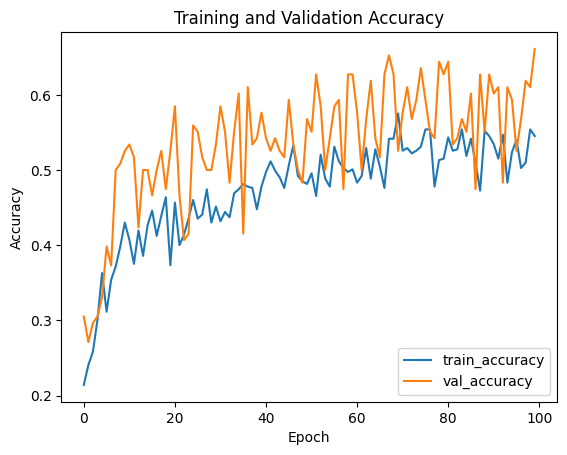

In [35]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
import numpy as np
import os
import matplotlib.pyplot as plt

# Chemins des dossiers de données
train_dir = '/content/gdrive/MyDrive/birds/Bird Speciees Dataset/train'
val_dir = '/content/gdrive/MyDrive/birds/Bird Speciees Dataset/validation'
test_dir = '/content/gdrive/MyDrive/birds/Bird Speciees Dataset/test'

# Paramètres du modèle
batch_size = 32
img_height, img_width = 224, 224  # Taille d'entrée pour ResNet50
num_classes = len(os.listdir(train_dir))  # Nombre de classes d'oiseaux

# Fonction pour ajouter du bruit aux images
def add_noise(image):
    img_array = img_to_array(image)
    noise = np.random.normal(loc=0, scale=25, size=img_array.shape)
    img_array = img_array + noise
    img_array = np.clip(img_array, 0, 255)
    return img_array  # Retourner un tableau NumPy

# Data Augmentation pour l'ensemble d'entraînement
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=[0.8, 1.2],
    horizontal_flip=True,
    brightness_range=[0.7, 1.3],
    #preprocessing_function=add_noise  # Ajoute du bruit aléatoire
)

# Data Augmentation pour les ensembles de validation et de test
val_test_datagen = ImageDataGenerator(rescale=1.0/255)

# Générateurs d'images
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Charger le modèle ResNet50 pré-entraîné (utilisé en remplacement de ResNet18)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Ajouter des couches de classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
output_layer = Dense(num_classes, activation='softmax')(x)  # Couche de sortie

# Construire le modèle final
model = Model(inputs=base_model.input, outputs=output_layer)

# Geler les couches du modèle de base pour un fine-tuning initial
for layer in base_model.layers:
    layer.trainable = False

# Compiler le modèle
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Entraîner le modèle
epochs = 100  # Peut être ajusté selon les besoins
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator
)

# Évaluer sur le set de test
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc * 100:.2f}%")

# Optionnel : Afficher les courbes d'entraînement
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()


Found 565 images belonging to 6 classes.
Found 118 images belonging to 6 classes.
Found 128 images belonging to 6 classes.
Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 26s 718ms/step - accuracy: 0.1820 - loss: 2.1554 - val_accuracy: 0.1695 - val_loss: 1.7385
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 297ms/step - accuracy: 0.2022 - loss: 1.9121 - val_accuracy: 0.2373 - val_loss: 1.7097
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 293ms/step - accuracy: 0.2501 - loss: 1.7717 - val_accuracy: 0.3390 - val_loss: 1.6495
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 302ms/step - accuracy: 0.2865 - loss: 1.7163 - val_accuracy: 0.3051 - val_loss: 1.6255
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 303ms/step - accuracy: 0.3221 - loss: 1.6611 - val_accuracy: 0.2966 - val_loss: 1.6127
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 298ms/step - accuracy: 0.2838 - loss: 1.6941 - val_accuracy: 0.4068 - val_loss: 1.5888
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 307ms/step - accuracy: 0.2798 - loss: 1.6868 - val_accuracy:

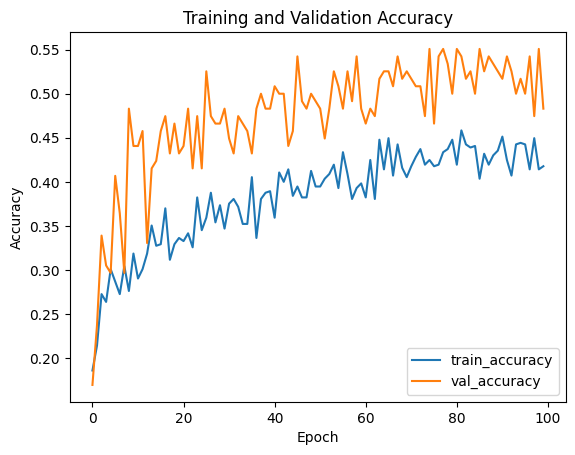

In [36]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
import numpy as np
import os
import matplotlib.pyplot as plt

# Chemins des dossiers de données
train_dir = '/content/gdrive/MyDrive/birds/Bird Speciees Dataset/train'
val_dir = '/content/gdrive/MyDrive/birds/Bird Speciees Dataset/validation'
test_dir = '/content/gdrive/MyDrive/birds/Bird Speciees Dataset/test'

# Paramètres du modèle
batch_size = 32
img_height, img_width = 224, 224  # Taille d'entrée pour ResNet50
num_classes = len(os.listdir(train_dir))  # Nombre de classes d'oiseaux

# Data Augmentation pour l'ensemble d'entraînement
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=[0.8, 1.2],
    horizontal_flip=True,
    brightness_range=[0.7, 1.3]
)

# Data Augmentation pour les ensembles de validation et de test
val_test_datagen = ImageDataGenerator(rescale=1.0/255)

# Générateurs d'images
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Charger le modèle ResNet50 pré-entraîné
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Ajouter des couches de classification avec Dropout
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)  # Dropout pour éviter le surapprentissage
output_layer = Dense(num_classes, activation='softmax')(x)

# Construire le modèle final
model = Model(inputs=base_model.input, outputs=output_layer)

# Geler les couches du modèle de base pour un fine-tuning initial
for layer in base_model.layers:
    layer.trainable = False

# Compiler le modèle
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Entraîner le modèle
epochs = 100  # Peut être ajusté selon les besoins
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator
)

# Évaluer sur le set de test
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc * 100:.2f}%")

# Optionnel : Afficher les courbes d'entraînement
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()


batch size smalle: 16, and dropout

Found 565 images belonging to 6 classes.
Found 118 images belonging to 6 classes.
Found 128 images belonging to 6 classes.
Epoch 1/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 26s 387ms/step - accuracy: 0.1456 - loss: 2.4557 - val_accuracy: 0.2881 - val_loss: 1.7303
Epoch 2/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 191ms/step - accuracy: 0.2353 - loss: 1.8163 - val_accuracy: 0.3559 - val_loss: 1.6557
Epoch 3/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 189ms/step - accuracy: 0.2559 - loss: 1.7227 - val_accuracy: 0.3051 - val_loss: 1.6562
Epoch 4/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 189ms/step - accuracy: 0.2935 - loss: 1.6671 - val_accuracy: 0.3559 - val_loss: 1.6230
Epoch 5/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 188ms/step - accuracy: 0.2680 - loss: 1.6459 - val_accuracy: 0.3051 - val_loss: 1.5909
Epoch 6/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 190ms/step - accuracy: 0.3647 - loss: 1.5855 - val_accuracy: 0.4576 - val_loss: 1.5477
Epoch 7/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 189ms/step - accuracy: 0.3273 - loss: 1.5920 - val_accuracy: 0.3983

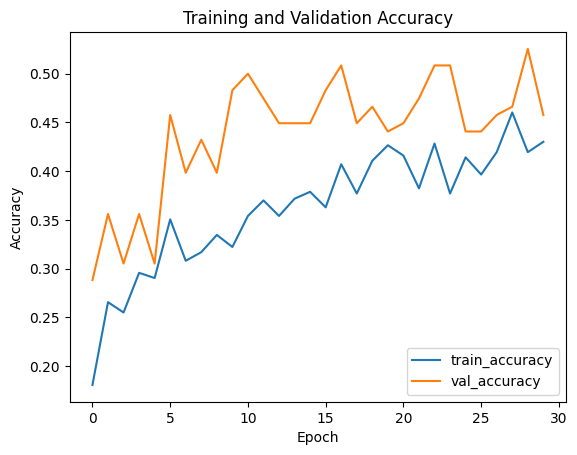

In [38]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import AdamW
import os
import matplotlib.pyplot as plt

# Chemins des dossiers de données
train_dir = '/content/gdrive/MyDrive/birds/Bird Speciees Dataset/train'
val_dir = '/content/gdrive/MyDrive/birds/Bird Speciees Dataset/validation'
test_dir = '/content/gdrive/MyDrive/birds/Bird Speciees Dataset/test'

# Paramètres du modèle
batch_size = 16
img_height, img_width = 224, 224  # Taille d'entrée pour ResNet50
num_classes = len(os.listdir(train_dir))  # Nombre de classes d'oiseaux

# Data Augmentation pour l'ensemble d'entraînement
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=[0.9, 1.1],
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)

# Data Augmentation pour les ensembles de validation et de test
val_test_datagen = ImageDataGenerator(rescale=1.0/255)

# Générateurs d'images
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Charger le modèle ResNet50 pré-entraîné
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Ajouter des couches de classification avec Dropout
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)  # Dropout pour éviter le surapprentissage
output_layer = Dense(num_classes, activation='softmax')(x)

# Construire le modèle final
model = Model(inputs=base_model.input, outputs=output_layer)

# Geler les couches du modèle de base pour un fine-tuning initial
for layer in base_model.layers:
    layer.trainable = False

# Compiler le modèle avec AdamW
model.compile(optimizer=AdamW(learning_rate=0.002, weight_decay=1e-5),  # weight_decay pour la régularisation
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Entraîner le modèle avec un nombre d'époques réduit
epochs = 30  # Nombre d'époques réduit pour éviter le surapprentissage
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator
)

# Évaluer sur le set de test
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc * 100:.2f}%")

# Optionnel : Afficher les courbes d'entraînement
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()


With AdamW and dropout

Found 565 images belonging to 6 classes.
Found 118 images belonging to 6 classes.
Found 128 images belonging to 6 classes.
Epoch 1/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 24s 375ms/step - accuracy: 0.2219 - loss: 2.4186 - val_accuracy: 0.1695 - val_loss: 1.7148
Epoch 2/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 195ms/step - accuracy: 0.2213 - loss: 1.8383 - val_accuracy: 0.4237 - val_loss: 1.6190
Epoch 3/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 188ms/step - accuracy: 0.3224 - loss: 1.6590 - val_accuracy: 0.3644 - val_loss: 1.6192
Epoch 4/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 191ms/step - accuracy: 0.2960 - loss: 1.6644 - val_accuracy: 0.4153 - val_loss: 1.5672
Epoch 5/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 189ms/step - accuracy: 0.3131 - loss: 1.6186 - val_accuracy: 0.4746 - val_loss: 1.5093
Epoch 6/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 189ms/step - accuracy: 0.3426 - loss: 1.5807 - val_accuracy: 0.4492 - val_loss: 1.4573
Epoch 7/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 189ms/step - accuracy: 0.3409 - loss: 1.5619 - val_accuracy: 0.4915

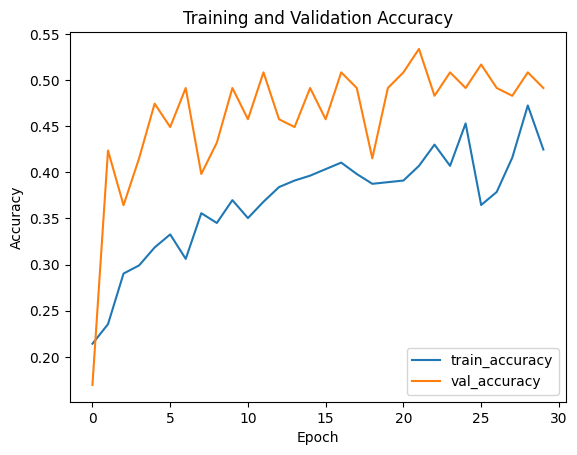

In [39]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import AdamW
import os
import matplotlib.pyplot as plt

# Chemins des dossiers de données
train_dir = '/content/gdrive/MyDrive/birds/Bird Speciees Dataset/train'
val_dir = '/content/gdrive/MyDrive/birds/Bird Speciees Dataset/validation'
test_dir = '/content/gdrive/MyDrive/birds/Bird Speciees Dataset/test'

# Paramètres du modèle
batch_size = 16
img_height, img_width = 224, 224  # Taille d'entrée pour ResNet50
num_classes = len(os.listdir(train_dir))  # Nombre de classes d'oiseaux

# Data Augmentation pour l'ensemble d'entraînement
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=[0.9, 1.1],
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)

# Data Augmentation pour les ensembles de validation et de test
val_test_datagen = ImageDataGenerator(rescale=1.0/255)

# Générateurs d'images
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Charger le modèle ResNet50 pré-entraîné
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Ajouter des couches de classification avec Dropout pour la régularisation
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)  # Dropout pour éviter le surapprentissage
output_layer = Dense(num_classes, activation='softmax')(x)

# Construire le modèle final
model = Model(inputs=base_model.input, outputs=output_layer)

# Geler les couches du modèle de base pour un fine-tuning initial
for layer in base_model.layers:
    layer.trainable = False

# Compiler le modèle avec AdamW
model.compile(optimizer=AdamW(learning_rate=0.002, weight_decay=1e-5),  # weight_decay pour la régularisation
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Entraîner le modèle avec un nombre d'époques réduit
epochs = 30  # Nombre d'époques réduit pour éviter le surapprentissage
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator
)

# Évaluer sur le set de test
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc * 100:.2f}%")

# Optionnel : Afficher les courbes d'entraînement
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()


Found 565 images belonging to 6 classes.
Found 118 images belonging to 6 classes.
Found 128 images belonging to 6 classes.
Epoch 1/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 19s 280ms/step - accuracy: 0.2006 - loss: 2.0243 - val_accuracy: 0.4831 - val_loss: 1.5862
Epoch 2/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.3861 - loss: 1.5950 - val_accuracy: 0.4576 - val_loss: 1.4322
Epoch 3/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.4361 - loss: 1.3835 - val_accuracy: 0.3644 - val_loss: 1.5833
Epoch 4/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.4995 - loss: 1.3169 - val_accuracy: 0.3644 - val_loss: 1.4661
Epoch 5/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.4830 - loss: 1.3083 - val_accuracy: 0.5678 - val_loss: 1.2447
Epoch 6/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.5479 - loss: 1.1620 - val_accuracy: 0.4746 - val_loss: 1.2805
Epoch 7/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.5456 - loss: 1.1680 - val_accuracy: 0.4746 - val

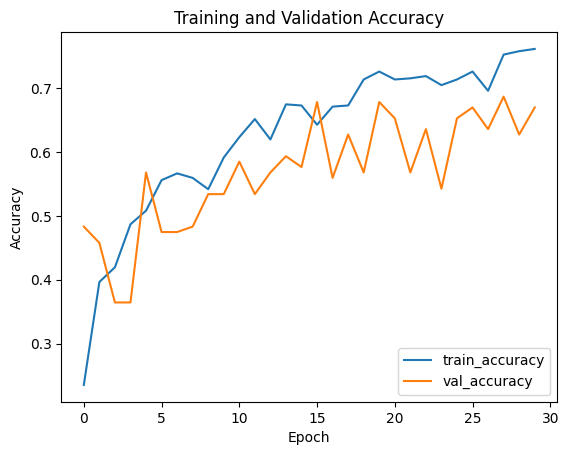

In [40]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import os
import matplotlib.pyplot as plt

# Chemins des dossiers de données
train_dir = '/content/gdrive/MyDrive/birds/Bird Speciees Dataset/train'
val_dir = '/content/gdrive/MyDrive/birds/Bird Speciees Dataset/validation'
test_dir = '/content/gdrive/MyDrive/birds/Bird Speciees Dataset/test'

# Paramètres du modèle
batch_size = 16
img_height, img_width = 224, 224  # Taille d'entrée pour ResNet50
num_classes = len(os.listdir(train_dir))  # Nombre de classes d'oiseaux

# Générateurs d'images sans data augmentation, seulement la normalisation
train_datagen = ImageDataGenerator(rescale=1.0/255)
val_test_datagen = ImageDataGenerator(rescale=1.0/255)

# Générateurs d'images
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Charger le modèle ResNet50 pré-entraîné
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Ajouter des couches de classification sans Dropout
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
output_layer = Dense(num_classes, activation='softmax')(x)

# Construire le modèle final
model = Model(inputs=base_model.input, outputs=output_layer)

# Geler les couches du modèle de base pour un fine-tuning initial
for layer in base_model.layers:
    layer.trainable = False

# Compiler le modèle avec l'optimiseur Adam
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Entraîner le modèle avec un nombre d'époques réduit
epochs = 30  # Nombre d'époques réduit pour éviter le surapprentissage
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator
)

# Évaluer sur le set de test
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc * 100:.2f}%")

# Optionnel : Afficher les courbes d'entraînement
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()


After trying many regularization methods, like dropping the batch size, adding more data augmentation, changing the optimizer to AdamW, dropout, the learning rate, or even changing the cost and activation function or adding more epochs, the model was getting less and less robust. Finally I tried the more basic one possible, without data augmentation and it had the best results. Sometimes maybe because of the set size, the model performs better with less complexity. So finally, from a model with 60% on the test accuracy, we passed thru 50% and finally 68% with the more basic model.